###  **This is a pretty long tutorial and I know how hard it is to go through, hopefully you may skip a few blocks of code if you need**

One of the oldest problem in Statistics is to deal with unbalanced data, for example, surviving data, credit risk, fraud. 

Basically in any data where either your success rate is too high or too low, models are almost irrelavant. This comes from the fact that we use a criteria around 1% to measure the accuracy of a model, ie, if my model predicts in the testing set 99% of the success (or failure depending on what you are trying to do), the model is a hero.

![title](images.png)

What happens with unbalanced data is that the success metric happening in around 1% (usually less than 10%), so if you have no model and predicts success at 1%, then the model passes the accuracy criteria.

In this post you will learn a 'trick' to deal with this type of data: *oversampling* and *undersampling*.
In this project I will skip the descriptive analysis hoping that we all want to focus on fraud analysis a bit more.


# Importing Libraries

In an early stage we will use a few of the most popular libraries such as pandas, numpy, matplotlib, sklearn, but also some for this particular type of problem such as imblearn, mlxtend and my favorite for logistic regression statsmodels.


In [63]:
#import libraries

#data manipulation
import pandas as pd
import numpy as np

#to plot stuff
import matplotlib.pyplot as plt
%matplotlib inline
import scikitplot as skplt
import matplotlib.gridspec as gridspec
import seaborn as sns



#split training and testing
from sklearn.model_selection import train_test_split

from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#machine learning 
import statsmodels.api as sm

#model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

I am also defining some of my output folder:

In [2]:
output_image = 'output/image/'
output_csv = 'ouput/csv/'

# Data Problem and Motivation

I have been working on a similar problem at work and I could not find a good source of information with I wanted. I knew I had to perform unbalanced data treatment and I wanted to use Logistic Regression and so I had to pick parts of code around and sew them together myself (thus this blog post).

The data used here was available in a kaggle competition 2 years ago in this link: https://www.kaggle.com/mlg-ulb/creditcardfraud. I have no extra knowledge of the data or data source whatsoever besides what is already in there. They do mention in the data description that a PCA analysis was performed and unfortunately, due to the nature of the business and privacy, they cannot release any additional information on the dataset.

This is what the data looks like:


In [3]:
#loads data
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Factoring the X matrix for Regression
If we take a closer look at the amount of success and failure in the original data, we have:

In [13]:
#define our original variables
y = df['Class']
features =list(df.columns[0:len(df.columns)-1])
X = pd.get_dummies(df[features], drop_first=True)

p = sum(y)/len(y)
print("Percentage of Fraud: "+"{:.3%}".format(p));

Percentage of Fraud: 0.173%


In [14]:
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


Now we know how low is the probability of a fradulent transactions to happen in our dataset (which here it will be treated as our success event). 

# Separating Test and Training
Let's separate the data in training and testing

In [15]:
#define training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


p_test = sum(y_test)/len(y_test)
p_train = sum(y_train)/len(y_train)

print("Percentage of Fraud in the test set: "+"{:.3%}".format(p_test))
print("Percentage of Fraud in the train set: "+"{:.3%}".format(p_train))


Percentage of Fraud in the test set: 0.172%
Percentage of Fraud in the train set: 0.173%


This way the percentage of success was kept within the split. 

Now because of our unbalanced data we need the dataset to have balanced success rate in order to validate the model. There are two ways of doing it: 
* Oversampling: which is basically floading the dataset with success events in a way that the percentage of success is closer to 50% (balanced) then the original set.
* Undersampling: which is reducing the unbalanced event, forcing the dataset to be balanced.

# Over and Under sampling

In [16]:
#generates both matrices for Over and Under sampling
#write  dataframe as a pandas dataframe and add the column names
#column names were removed from the dataframe when we performed the transformation
#column names will be useful down the road when we do a feature selection

ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X_train, y_train)

X = pd.DataFrame(X)
names = list(X.columns)
X_over = pd.DataFrame(X_over)
X_over.columns = names


#under
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)

X_under = pd.DataFrame(X_under)
X_under.columns = names

p_over = sum(y_over)/len(y_over)
p_under = sum(y_under)/len(y_under)

print("Percentage of Fraud in the test set: "+"{:.3%}".format(p_over))
print("Percentage of Fraud in the train set: "+"{:.3%}".format(p_under))

Percentage of Fraud in the test set: 50.000%
Percentage of Fraud in the train set: 50.000%


Now the data has the same amount of success and failures.

# Modeling with Logistic Regression

In the snipped of code below we have three function:

1. **remove_pvalues():** a function to perform feature selection. It removes features with a p-value higher than 5%, which is basically the probability of the weight for that feature being equal 0. In a regression fitting, the coefficients pvalue test if each individual feature is irrelevant for the model (null hypothesis) or otherwise (alternative hypothesis). If you want to know more the Wikipedia article on p-value is pretty reasanable (https://en.wikipedia.org/wiki/P-value)

<br>

2. **stepwise_logistic():** now we will repeat the process of removing the "irrelavant features" until there is no more fetaures to be removed. This function will loop through the model interactions until stops removing features.

<br>

3. **logit_score():** The output of a logistic regression model is actually a vector of probabilities from 0 to 1, the closer to 0 the more unlikely is of that record to be a fraud given the current variables in the model. And on another hand the closer to 1, the more likely is to be a fraud. For the purposes of this problem, if the probability is higher than 0.95 (which it was picked by me randomly and guttely speaking) I am calling that a 1. And then at the end, this function scores the predicted success rate against the real value of the testing set.

Note: The IMO the threshold to call a fraud or success depends on how many false negative/positive you are willing to accept. In statistics, it's impossible to control both at the same time, so you need to pick and choose.

In [17]:
#the functions below perform the stepwise selection using backward method based on feature weight
#this functionality is not created in python (specially for logistic regression) within the statsmodels package
#the function orders the p-values from the highest to the lowest and then remove one at a time refitting the model 
#each time checking if the features change their relevance. 

#the second function scores the model rounding likelihood higher than  0.95 to 1 (assuming it's a fraud)


#function to do the stepwise backward selection
def new_stepwise(X, y, alpha):
    
    #creates empty list
    to_remove = ['']
    
    n_old = len(X.columns)
    n_new = 0
    

    #have we stop seeing high p-values?
    while n_old - n_new>0:
        
        n_old = len(X.columns)
        
        #run the model 
        lr=sm.Logit(y, X)
        lr = lr.fit(disp=0)
        lr.pvalues = lr.pvalues.sort_values(ascending=False)
        
        k = 0
        #are we at the last one of the pvalues
        while k < n_old:


            if lr.pvalues.iloc[k]<alpha: 

                k +=1
            else:
                
                print(lr.pvalues.index[k])
                to_remove.append(lr.pvalues.index[k])
                X = X[X.columns.difference(to_remove)]
                break

                
        n_new = len(X.columns)


    return X.columns

def logit_score(model, X, y, threshold=0.95):
    #function to score the logit model (only works for models that support .predict function)
    y_t = model.predict(X)
    y_t = y_t > threshold
    z= abs(y_t-y)
    score = 1- sum(z)/len(z)
    return score
    

In [18]:
def confusion_matrix_lr(output_path, model_name, trigger, model, X, y_real, method, financed='none'):
    
    """ 
    function to create the confusion matrix and save it in a selected location and return the predicted value using
    the function. this works in any function that has a binary response and accepts .predict on indepentente matrix
    output_path: file location
    model_name = file name to be used when saving it
    trigger: it the threshold chosen to determine fraud or not
    X: predicted matrix used, usually in the testing set
    y_real = the real values to be compared with
    
    output: --a PNG file saved in the output_path
    -- a vector with the predicted values (1 as success 0 as failure)
    
    """
    
    y_pred = model.predict(X)
    y_pred = y_pred>trigger
    y_pred = y_pred*1
    
    
    save_confusionmatrix(output_path, model_name, trigger, y_real, y_pred, method, financed);

    
    return y_pred

def save_confusionmatrix(output_path, model_name, trigger, y_real, y_pred, method, financed= 'none'):
    
    'for the function above this is where the saving image actually happens'
    
    if method=='pred':
        confusion_matrix = skplt.metrics.plot_confusion_matrix(y_real, y_pred);
    else:
        confusion_matrix = plot_confusion_matrix_value_new(y_real, y_pred, financed);
        
    confusion_matrix.figure.savefig(f'{output_path}confusion_matrix_'+model_name+'_'+str(trigger)+'.JPEG')
    confusion_matrix.figure.show
    return confusion_matrix 

## Performing Logistic Regression
Now our guns are loaded, we just need to fire, below I am performing the feature selection and then the model fitting in the final X matrix:

## Singularity and Colinearity

One of the things that the Logistic Regression does is invert the X matrix, if X has two columns with colinearity, in another words, a column is a linear combination of the other, we then have the issue of Singular Matrix, which is one of the worst problems a Statistician can face.

The functions below were created to solve this problem:

- function order_correlation_matrix: calculates correlation between all the variables of a given dataframe, removes the diagonal value, vectorized in var1, var 2 and their respective correlation and sort by the highest correlation.
- function remove_features: remove the feature until there is no correlation higher than a given corr_value, which is determined by the user



In [19]:
def order_correlation_matrix(df):
    ''' calculates the correlation matrix and order the values from high correlated to low'''
    corr_matrix = df.corr().abs() #calculates correlation matrix
    s = corr_matrix.unstack()
    so=pd.DataFrame(s)
    so = so.reset_index()
    so.columns = ['var1', 'var2', 'corr']
    so = so.sort_values(by='corr', ascending=False)
    so = so[so['corr']!=1]
    
    return so



def remove_features(df, corr_value):
    '''
    receives a dataframe with X matrix and returns features from X that needs to be removed based on 
    '''    
    
    n_before = 0
    n_after = 1
    remove = []
    
    while(n_after>n_before):
        n_before = n_after

        so = order_correlation_matrix(df)
        if(so['corr'].iloc[0]>=corr_value):
            remove.append(so['var1'].iloc[0])
            n_after = len(remove)
    return remove

In [20]:
threshold = 0.9
#execute the functions over

over_features = new_stepwise(X_over, y_over, 0.05)
X_over_new = X_over[over_features]

lr_os=sm.Logit(y_over,X_over_new) #os stands for oversampling
lr_os = lr_os.fit()

V20
Optimization terminated successfully.
         Current function value: 0.150160
         Iterations 14


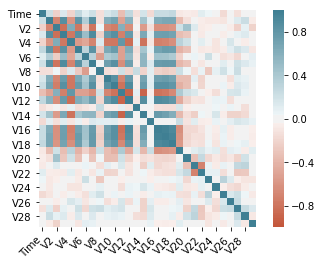

In [21]:
#correlation matrix 
corr = X_under.corr()

# plot the correlation matrix
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [24]:
#removes columns with high collinear
X_under = X_under[X_under.columns.difference(remove_features(X_under, 0.9))] 
# stepwise backward selction 
under_features = new_stepwise(X_under, y_under, 0.05)

lr_us=sm.Logit(y_under,X_under[under_features]) #os stands for undersampling
lr_us = lr_us.fit()


V22
V13
V19
V24
V26
V15
V27
V11
Optimization terminated successfully.
         Current function value: 0.136531
         Iterations 13


In [176]:
#Optimum value for threshold
def model_threshold_finder(start, interval, y_real, y_prob, modelname):

    '''
    calculates precision and recall for y_real versus y_pred looping through a set of values between 0 and 1
    input - 
    y_real: is the vector os 1s and 0 of the real data.
    y_prob: is the vector of probabilities predicted by the LR model
    intervall: is how many intervalls you want between 0 and 1 to have the precision and recall to be calculated on
    output - 

    a dataframe with the values
    a plot plotting precision versus recall by threshold 
    '''
    
    threshold_list = np.arange(start, 1.000001, interval)
    precision = []
    recall = []
    trigger = []

    
    for threshold in threshold_list:
        y_pred = y_prob>threshold
        y_pred = y_pred*1
        trigger.append(threshold)
        precision.append(precision_score(y_real, y_pred))
        recall.append(recall_score(y_real, y_pred))
        
    dataframe  = pd.DataFrame(data = {'trigger': trigger, 'precision': precision, 'recall':recall})

    #creates the vector of probabilities of 0 and 1s
    y_probas = np.array([1-y_prob, y_prob])
    y_probas = np.transpose(y_probas)
    
    #plots the precision-recall chart
    skplt.metrics.plot_precision_recall(y_test, pred_test, title = 'Precision-Recall Curve %s' %modelname, 
                                        title_fontsize = 20)
    dataframe['evaluator'] = dataframe['precision'] * dataframe['recall']
    
    return dataframe



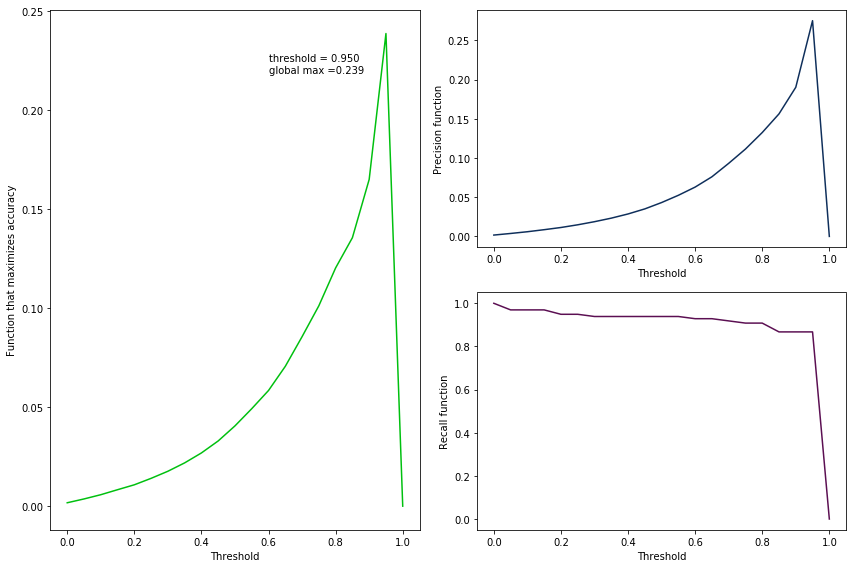

In [327]:
def draw_precision_recall(interval_range, dataframe):
    

    fig = plt.figure(1)
    plt.gcf().set_size_inches(12, 8) #sets size of the image    
    gridspec.GridSpec(2,2) #creates grids (in this case is 2 by 2)
    
    
    
    #calculates the global max = 
    ymax = max(dataframe['evaluator'])
    xmax = dataframe[dataframe['evaluator'] == ymax]['trigger'].values[0]

    #plot 1
    plt.subplot2grid((2,2), (0,0), colspan=1, rowspan=2)
    plt.xlabel('Threshold')
    plt.ylabel('Function that maximizes accuracy')
    plt.plot(dataframe['trigger'], dataframe['evaluator'],  color = '#00C00F')
    text= "threshold = {:.3f} \nglobal max ={:.3f}".format(xmax, ymax)
    plt.annotate(text, xy=(xmax-0.35, ymax-0.02))
    
    #plot 2
    plt.subplot2grid((2,2), (0,1), colspan=2)
    plt.xlabel('Threshold')
    plt.ylabel('Precision function')
    plt.plot(dataframe['trigger'], dataframe['precision'], color='#0F2F5B')    
    
    #plot 3
    plt.subplot2grid((2,2), (1,1), colspan=2)
    plt.xlabel('Threshold')
    plt.ylabel('Recall function')        
    plt.plot(dataframe['trigger'], dataframe['recall'], color='#5B0F52')

    
    

    

    fig.subplots_adjust(hspace=0)
    fig.tight_layout()
    


start = 0
interval = 0.05
threshold_list = np.arange(start, 1.000001, interval)
draw_precision_recall(threshold_list, classification_1)

In [313]:
ymax = max(classification_1['evaluator'])
xmax = classification_1[classification_1['evaluator'] == ymax]['trigger'].values[0]

type(xmax)
xmax

0.9500000000000001

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


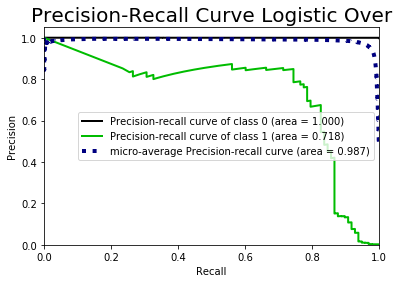

In [292]:
y_os_prob = lr_os.predict(X_test[over_features])
y_us_prob = lr_us.predict(X_test[under_features])

classification_1 = model_threshold_finder(start, interval, y_test, y_os_prob, 'Logistic Over')


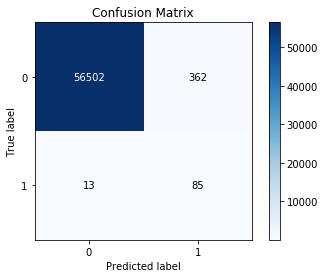

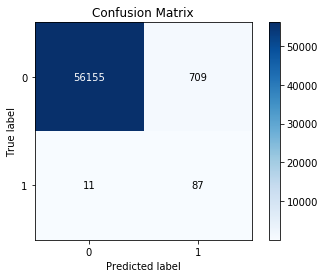

In [45]:
#generates pred and saves confusion matrix
y_test_pred_os = confusion_matrix_lr(output_image, 'lr_os', threshold, lr_os, X_test[over_features], y_test, method = 'pred', )
y_test_pred_us = confusion_matrix_lr(output_image, 'lr_us', threshold, lr_us, X_test[under_features], y_test, method = 'pred', )

## Scoring the model

Now let's compare the two models 


Now the most expected part of this tutorial, which is basically checking how many "rights and wrongs" we are getting, considering the model was created based on a dataset with a 50% of fraud occurrences, and then tested in a set with 0.17% of fraud occurrences.<br>
**Voila:**

In [ ]:
score = logit_score(lr, X_test[features], y_test)
y_t = lr.predict(X_test[features])
#rounds to 1 any likehood higher than 0.95, otherwise sign 0
y_t = y_t > 0.95

print("Percentage of Rights and Wrongs in the testing set "+"{:.3%}".format(score));


In [ ]:
#from the number below you can see if the model is over or under predicting
print('Number of Frauds in real data %s' % sum(y_test))
print('Number of Frauds in prediction data %s' % sum(y_t))

Now that we know the model is ok, let's see where we are getting it wrong. The plot below shows how many false negatives and false positives we have. We see a lot more false positives (we are saying a transaction was fradulent even though it was not). This come from the 0.95 threeshold above, if you increase that value to 0.99 for example, you will increase the amount of false negatives as well. The statistician need to decide what is the cut minimizes false negatives without affecting precision.


In [ ]:
#plots confusion matrix with false positives and negatives
skplt.metrics.plot_confusion_matrix(y_test, y_t)

let's see what variables are more important to the model in asbolute value. In the chart below you can see the top 15 most relavant features:

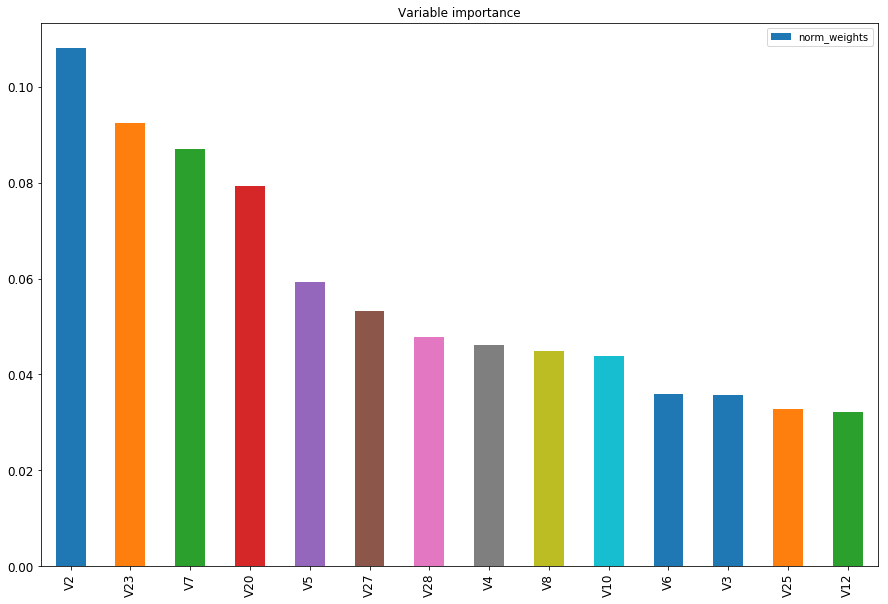

In [29]:
#calculate the weights
weights = lr.params

#creates a dataframe for them and the coefficient names
importance_list = pd.DataFrame(
    {'names': features,
     'weights': weights
    })

#normalized absolute weights
importance_list['abs_weights'] = np.abs(importance_list['weights'])
total = sum(importance_list['abs_weights'])
importance_list['norm_weights'] = importance_list['abs_weights']/total

#select top 10 with higher importance
importance_list = importance_list.sort_values(by='norm_weights', ascending=False)
importance_list = importance_list.iloc[0:14]

#plot them tcharam!
ax = importance_list['norm_weights'].plot(kind='bar', title ="Variable importance",figsize=(15,10),legend=True, fontsize=12)
ax.set_xticklabels(importance_list['names'], rotation=90)

plt.show()

Now to visualize the weights we can see in the plot below which variables decrease x increase the likelihood of having a fradulent transaction. 

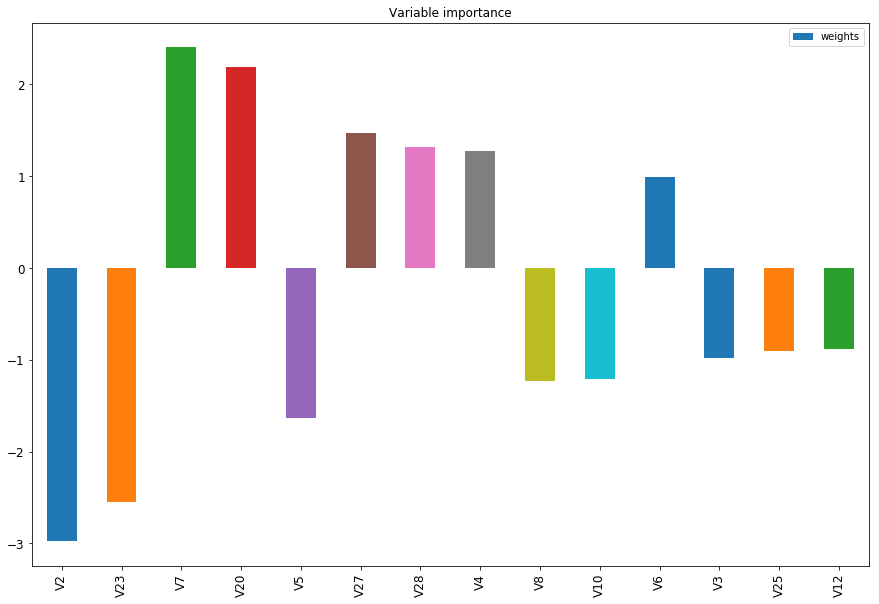

In [30]:
ax = importance_list['weights'].plot(kind='bar', title ="Variable importance",figsize=(15,10),legend=True, fontsize=12)
ax.set_xticklabels(importance_list['names'], rotation=90)

plt.show()

In [ ]:
I know this is a pretty long tutorial but hopefully you will not need to go through all the yak shaving I had to go through what I went through.